In [1]:
import os
from dataclasses import dataclass, field
from typing import Union
import numpy as np
from scipy.linalg import cholesky
from scipy import signal
from scipy.spatial.transform import Rotation as R
import pandas as pd

import json
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints


# Make matplotlib interractive in jupyter
%matplotlib widget

In [2]:
class Location3d:
    # Names to use in the state vector
    state_names = [
        'x_w', 'y_w', 'z_w', # Position (world frame)
        'vx_w', 'vy_w', 'vz_w', # Velocity (world frame)
        'ax_b', 'ay_b', 'az_b', # Acceleration (body frame)
        'qa_w', 'qb_w', 'qc_w', 'qd_w', # Orientation quaternions (world frame)
        'wpi_b', 'wro_b', 'wya_b' # Angular velocity (body frame)
    ]
    # Gravity magnitude
    # g = 9.80665
    g = 9.80339

    def __init__(self, sample_rate, init_r: R = None):
        self.dt = 1/sample_rate
        self.dim_x = len(Location3d.state_names)
        init_state = [0]*self.dim_x
        if init_r is None:
            init_r = R.identity()
        init_state[9:13] = init_r.as_quat()
        self.state_history = [init_state]

    def add_measurement(self, accelerometer, gyroscope):
        # Unpack the last state
        x_w, y_w, z_w, vx_w, vy_w, vz_w, ax_b, ay_b, az_b, qa_w, qb_w, qc_w, qd_w, wpi_b, wro_b, wya_b = self.state_history[-1]
        # Get the measurements from the body
        ax_b, ay_b, az_b = accelerometer
        wpi_b, wro_b, wya_b = gyroscope
        # Insert them into the state
        x = x_w, y_w, z_w, vx_w, vy_w, vz_w, ax_b, ay_b, az_b, qa_w, qb_w, qc_w, qd_w, wpi_b, wro_b, wya_b
        # Update the state
        x_new = Location3d.state_transition_function(x, self.dt)
        self.state_history.append(x_new)
        
    @staticmethod
    def state_transition_function(x, dt):
        # Extract state variables
        x_w, y_w, z_w, vx_w, vy_w, vz_w, ax_b, ay_b, az_b, qa_w, qb_w, qc_w, qd_w, wpi_b, wro_b, wya_b = x

        # Convert the acceleration in the body frame to the world frame
        rotation_w = R.from_quat([qa_w, qb_w, qc_w, qd_w])
        # TODO don't know if this is inverse or not
        # ax_w, ay_w, az_w = rotation_w.inv().apply(np.array([ax_b, ay_b, az_b]))
        ax_w, ay_w, az_w = rotation_w.apply(np.array([ax_b, ay_b, az_b]))

        # Update the linear velocity
        vx_w += ax_w * dt
        vy_w += ay_w * dt
        vz_w += (az_w - Location3d.g) * dt
        # Update the position
        x_w += vx_w * dt
        y_w += vy_w * dt
        z_w += vz_w * dt

        # Calculate the change in rotation
        angular_velocity = np.array([wpi_b, wro_b, wya_b])
        rotation_vector = angular_velocity * dt
        delta_rotation = R.from_rotvec(rotation_vector)
        
        # Update the current orientation by multiplying with the delta rotation
        rotation_w = rotation_w * delta_rotation
        qa_w, qb_w, qc_w, qd_w = rotation_w.as_quat()

        # New state vector (x_new)
        return np.array([
            x_w, y_w, z_w, vx_w, vy_w, vz_w, ax_b, ay_b, az_b, qa_w, qb_w, qc_w, qd_w, wpi_b, wro_b, wya_b
        ])
    
    def get_state_history_df(self):
        df = pd.DataFrame(self.state_history, columns=Location3d.state_names)
        # Convert quantenions to euler angles in radidans
        df['ya_w'], df['pi_w'], df['ro_w'] = R.from_quat(df[['qa_w', 'qb_w', 'qc_w', 'qd_w']].values).as_euler('xyz').T
        return df


@dataclass
class UkfConfig:
    # Number of state dimensions
    state_n: int
    # Number of measurement dimensions
    measurement_n: int
    # Alpha determines the spread of the sigma points, with smaller values resulting in a tighter spread
    alpha: float = 1e-3
    # Set beta to 2 for Gaussian distributions
    beta: float = 2
    # Set kappa to 0 initially (secondary scaling parameter)
    kappa: float = 0
    # Init state
    init_r: R = None

    # When an single value, the following parameters define the diagonals, otherwise they define the full matrix
    # Measurement noise covariance
    R: Union[float, np.ndarray] = field(default_factory=lambda: 0)
    # Process noise covariance (Too slow to react? Increase Q; Too sensitive to noise? Decrease the Q)
    Q: Union[float, np.ndarray] = field(default_factory=lambda: 1e-4)
    # Initial state covariance (Small values if confident, large values between 1-10 suggestaed when not)
    P: Union[float, np.ndarray] = field(default_factory=lambda: 1e-5)

    def __post_init__(self):
        if np.isscalar(self.R):
            self.R = np.eye(self.measurement_n)*self.R
        if np.isscalar(self.Q):
            self.Q = np.eye(self.state_n)*self.Q
        if np.isscalar(self.P):
            self.P = np.eye(self.state_n)*self.P


class Location3dUkf(Location3d):
    def __init__(self, sample_rate, config: UkfConfig) -> None:
        super().__init__(sample_rate, init_r=config.init_r)

        self.ukf = UnscentedKalmanFilter(
            dim_x=self.dim_x, dim_z=6, dt=self.dt,
            fx=Location3d.state_transition_function, hx=Location3dUkf.measurement_function,
            points=MerweScaledSigmaPoints(self.dim_x, alpha=config.alpha, beta=config.beta, kappa=config.kappa)
        )

        # Initial state
        self.ukf.x = self.state_history[0]
        # Matrix configurations
        self.ukf.R = config.R
        self.ukf.Q = config.Q
        self.ukf.P = config.P

    @staticmethod
    def measurement_function(x):
        # Extract state variables
        # x_w, y_w, z_w, vx_w, vy_w, vz_w, ax_b, ay_b, az_b, pi_w, ro_w, ya_w, wpi_b, wro_b, wya_b = x
        x_w, y_w, z_w, vx_w, vy_w, vz_w, ax_b, ay_b, az_b, qa_w, qb_w, qc_w, qd_w, wpi_b, wro_b, wya_b = x
        # Measurement vector (z)
        return np.array([ax_b, ay_b, az_b, wpi_b, wro_b, wya_b])
    
    def add_measurement(self, accelerometer, gyroscope):
        # The measurement vector (z) from the body frame
        z_b = np.hstack((accelerometer, gyroscope))
        # Call the `predict` and `update` methods of the UnscentedKalmanFilter class
        self.ukf.predict()
        self.ukf.update(z_b)
        self.state_history.append(self.ukf.x.copy())


In [3]:
sample_rate = 417
dt = 1 / sample_rate

# Generate fake data
a = 0.5
g_f = Location3d.g
accelerometer = [[a, 0, g_f]]*sample_rate + [[-a, 0, g_f]]*sample_rate
accelerometer += [[0, a, g_f]]*sample_rate + [[0, -a, g_f]]*sample_rate
accelerometer += [[-a, 0, g_f]]*sample_rate + [[a, 0, g_f]]*sample_rate
accelerometer += [[0, -a, g_f]]*sample_rate + [[0, a, g_f]]*sample_rate
accelerometer = np.array(accelerometer)
# Generate simulated accelerometer and gyroscope data
gyroscope = np.zeros((len(accelerometer), 3), dtype=float)
# Gryo spins up and then spins down
w = 0.1
gyroscope[:sample_rate, 2] = np.linspace(0, w, sample_rate)
gyroscope[sample_rate:2*sample_rate, 2] = np.linspace(w, 0, sample_rate)

UKF Final Location: 0.013, -0.258, -0.000
DR Final Location: 0.013, -0.258, 0.000


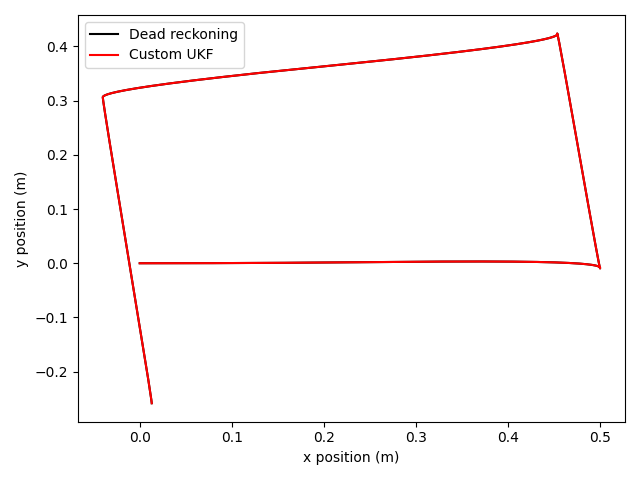

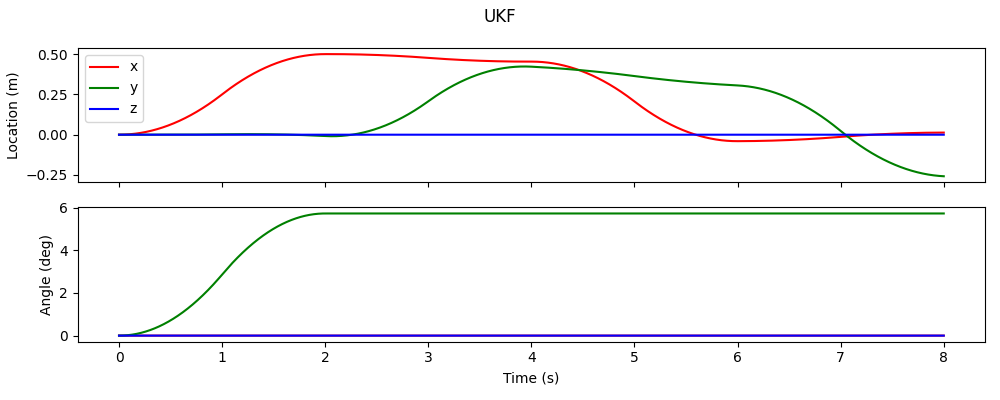

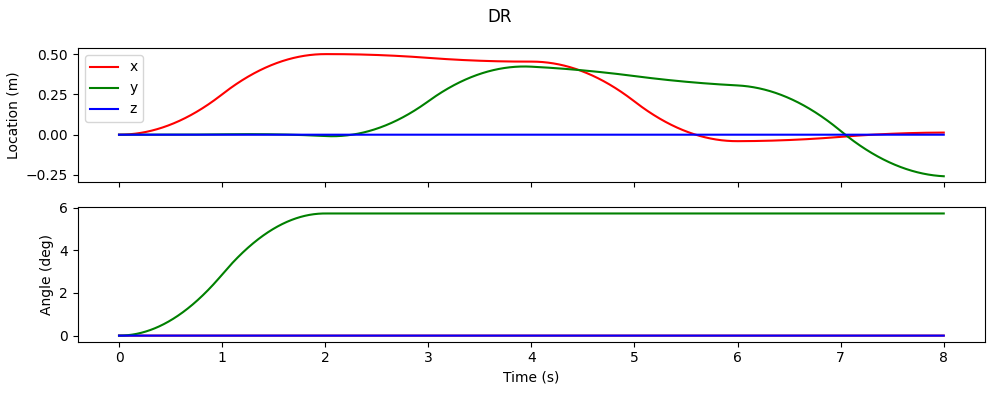

(<__main__.Location3dUkf at 0x111dba170>, <__main__.Location3d at 0x111db9a80>)

In [4]:
def plot_est(state_df, sample_rate, title):
    t = np.arange(len(state_df))/sample_rate
    # Plot the estimated locations, and angles over time, with time axis in seconds, in 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
    fig.suptitle(title)
    ax1.plot(t, state_df['x_w'], 'r', label='x')
    ax1.plot(t, state_df['y_w'], 'g', label='y')
    ax1.plot(t, state_df['z_w'], 'b', label='z')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Location (m)')
    ax2.plot(t, state_df['pi_w']/(2*np.pi)*360, 'r', label='pitch')
    ax2.plot(t, state_df['ro_w']/(2*np.pi)*360, 'g', label='roll')
    ax2.plot(t, state_df['ya_w']/(2*np.pi)*360, 'b', label='yaw')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angle (deg)')
    plt.tight_layout()
    plt.show()


def run_location_tests(accelerometer, gyroscope, sample_rate, config, init_r=None):
    dr_obj = Location3d(sample_rate=sample_rate, init_r=init_r)
    ukf_obj = Location3dUkf(
        sample_rate=sample_rate,
        config=config
    )

    for i in range(len(accelerometer)):
        dr_obj.add_measurement(accelerometer[i], gyroscope[i])
        ukf_obj.add_measurement(accelerometer[i], gyroscope[i])

    state_df_ukf = ukf_obj.get_state_history_df()
    x_ukf = state_df_ukf['x_w'].to_numpy()
    y_ukf = state_df_ukf['y_w'].to_numpy()

    state_df_dr = dr_obj.get_state_history_df()
    x_dr = state_df_dr['x_w'].to_numpy()
    y_dr = state_df_dr['y_w'].to_numpy()

    print(f'UKF Final Location: {state_df_ukf.iloc[-1]["x_w"]:0.3f}, {state_df_ukf.iloc[-1]["y_w"]:0.3f}, {state_df_ukf.iloc[-1]["z_w"]:0.3f}')
    print(f'DR Final Location: {state_df_dr.iloc[-1]["x_w"]:0.3f}, {state_df_dr.iloc[-1]["y_w"]:0.3f}, {state_df_dr.iloc[-1]["z_w"]:0.3f}')

    plt.figure()
    plt.plot(x_dr, y_dr, 'k', label='Dead reckoning')
    plt.plot(x_ukf, y_ukf, 'r', label='Custom UKF')
    plt.legend(loc='upper left')
    plt.xlabel('x position (m)')
    plt.ylabel('y position (m)')
    plt.tight_layout()
    plt.show()

    plot_est(state_df_ukf, sample_rate, 'UKF')
    plot_est(state_df_dr, sample_rate, 'DR')

    return ukf_obj, dr_obj

config = UkfConfig(len(Location3d.state_names), 6, alpha=1e3, beta=2, kappa=0, Q=1e-4, P=1e-6)
run_location_tests(accelerometer, gyroscope, sample_rate, config)

In [5]:
ACCELEROMETER_SCALE = 1.000576332
GYROSCOPE_SCALE = 2*np.pi/360

# Read in json file
# file = 'data-zero.json'
# file = '3d_rotate.json'
file = 'static_1.json'
with open(os.path.join('..', 'tmp', file)) as f:
    data = json.load(f)
accelerometer = np.array(data['accelerometer'])*ACCELEROMETER_SCALE
gyroscope = np.array(data['gyro'])*GYROSCOPE_SCALE
sample_rate = 417

# Read calibration data
file = 'calibration.json'
with open(file) as f:
    calibration = json.load(f)

accelerometer = accelerometer*calibration['accelerometer_sensitivity'] - np.array(calibration['accelerometer_offset'])
gyroscope -= np.array(calibration['gyroscope_offset'])

In [6]:
def run_butter_filter(in_signal, sample_rate, highpass=None, lowpass=None, order=2):
    if lowpass is None and highpass is not None:
        filter_cutoff = [highpass]
        f_type = 'highpass'
    elif highpass is None and lowpass is not None:
        filter_cutoff = [lowpass]
        f_type = 'lowpass'
    elif highpass is not None and lowpass is not None:
        filter_cutoff = [highpass, lowpass]
        f_type = 'bandpass'
    else:
        raise NotImplementedError

    sos = signal.butter(order, filter_cutoff, f_type, fs=sample_rate, output='sos')
    return signal.sosfiltfilt(sos, in_signal)

# Filter each axis of the accelerometer
lp = 150
accelerometer[:, 0] = run_butter_filter(accelerometer[:, 0], sample_rate, lowpass=lp, order=3)
accelerometer[:, 1] = run_butter_filter(accelerometer[:, 1], sample_rate, lowpass=lp, order=3)
accelerometer[:, 2] = run_butter_filter(accelerometer[:, 2], sample_rate, lowpass=lp, order=3)
gyroscope[:, 0] = run_butter_filter(gyroscope[:, 0], sample_rate, lowpass=lp, order=3)
gyroscope[:, 1] = run_butter_filter(gyroscope[:, 1], sample_rate, lowpass=lp, order=3)
gyroscope[:, 2] = run_butter_filter(gyroscope[:, 2], sample_rate, lowpass=lp, order=3)

In [7]:
# Remove first seconds of data
cut_time = 2
accelerometer = accelerometer[int(sample_rate*cut_time):]
gyroscope = gyroscope[int(sample_rate*cut_time):]

In [8]:
def initial_rotation_from_accelerometer(accel_data):
    # Assuming the robot is stationary, the acceleration vector should be pointing opposite to the gravity vector
    ax, ay, az = accel_data

    # Compute pitch and roll angles from accelerometer data
    roll = np.arctan2(ay, np.sqrt(ax**2 + az**2))
    pitch = np.arctan2(-ax, np.sqrt(ay**2 + az**2))

    # Create the initial rotation as a Rotation object
    initial_rotation = R.from_euler('zyx', [0, pitch, roll])  # yaw is set to zero as it cannot be determined using only accelerometer

    return initial_rotation

# init_r = initial_rotation_from_accelerometer(np.mean(accelerometer, axis=0))
# print(init_r.as_euler('xyz', degrees=False))
init_r = initial_rotation_from_accelerometer(np.mean(accelerometer[:int(0.1*sample_rate)], axis=0))
print(init_r.as_euler('xyz', degrees=False))

[1.64113699e-04 1.96096241e-03 3.21820591e-07]


Accelerometer mean +/- std
x: -0.021 +/- 0.010
y: 0.004 +/- 0.009
z: 9.829 +/- 0.011
Gyro mean +/- std
x: 0.000 +/- 0.001
y: -0.000 +/- 0.001
z: -0.000 +/- 0.001


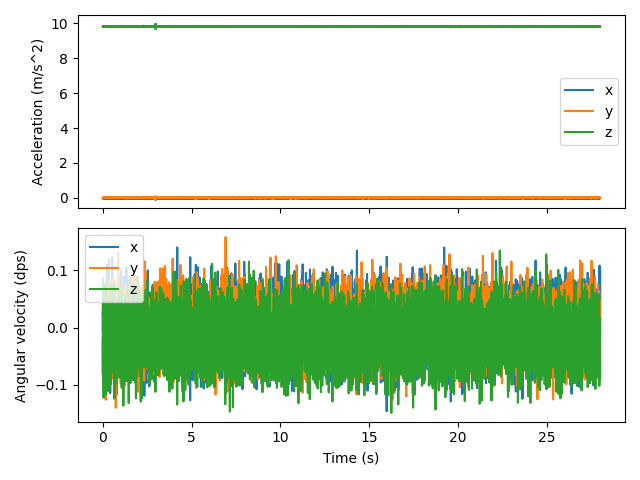

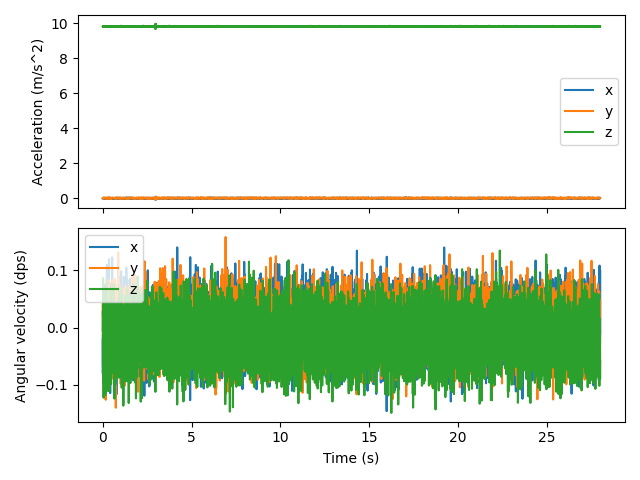

In [9]:
def plot(accelerometer, gyro, sample_rate):
    # Plot the accelerometer data in one subplot and the gyro data in another with shared x axis, time axis has a sample rate of 417 Hz
    t = np.arange(len(accelerometer)) / sample_rate
    accelerometer = np.array(accelerometer)
    gyro = np.array(gyro)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(t, accelerometer[:, 0], label='x')
    ax1.plot(t, accelerometer[:, 1], label='y')
    ax1.plot(t, accelerometer[:, 2], label='z')
    ax1.set_ylabel('Acceleration (m/s^2)')
    ax1.legend()
    ax2.plot(t, gyro[:, 0]*360/(2*np.pi), label='x')
    ax2.plot(t, gyro[:, 1]*360/(2*np.pi), label='y')
    ax2.plot(t, gyro[:, 2]*360/(2*np.pi), label='z')
    ax2.set_ylabel('Angular velocity (dps)')
    ax2.set_xlabel('Time (s)')
    ax2.legend()
    fig.tight_layout()

plot(accelerometer, gyroscope, sample_rate)
plot(init_r.apply(accelerometer), gyroscope, sample_rate)

# Print mean +/- standard deviation of the accelerometer and gyro data
print('Accelerometer mean +/- std')
print(f'x: {np.mean(accelerometer[:, 0]):0.3f} +/- {np.std(accelerometer[:, 0]):0.3f}')
print(f'y: {np.mean(accelerometer[:, 1]):0.3f} +/- {np.std(accelerometer[:, 1]):0.3f}')
print(f'z: {np.mean(accelerometer[:, 2]):0.3f} +/- {np.std(accelerometer[:, 2]):0.3f}')
print('Gyro mean +/- std')
print(f'x: {np.mean(gyroscope[:, 0]):0.3f} +/- {np.std(gyroscope[:, 0]):0.3f}')
print(f'y: {np.mean(gyroscope[:, 1]):0.3f} +/- {np.std(gyroscope[:, 1]):0.3f}')
print(f'z: {np.mean(gyroscope[:, 2]):0.3f} +/- {np.std(gyroscope[:, 2]):0.3f}')

9.829389182096659


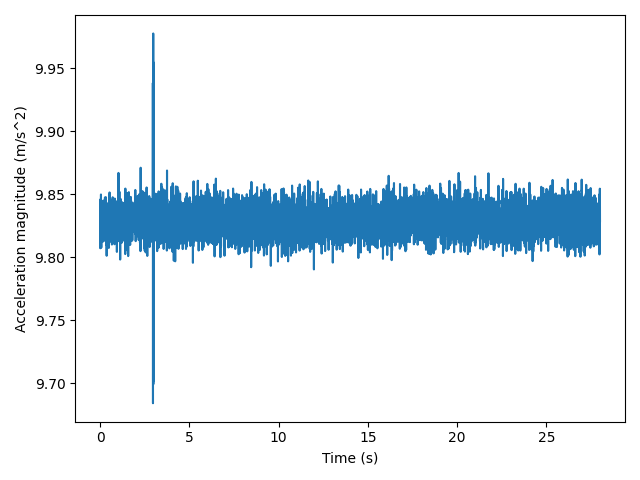

In [10]:
# Calculate total magnitude of acceleration
accelerometer_mag = np.linalg.norm(accelerometer, axis=1)
t = np.arange(len(accelerometer_mag)) / sample_rate
# Plot acceleration magnitude
plt.figure()
plt.plot(t, accelerometer_mag)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration magnitude (m/s^2)')
plt.tight_layout()

print(np.mean(accelerometer_mag))

UKF Final Location: 1457.582, 2491.553, 1671.886
DR Final Location: -0.867, -1.667, 10.155


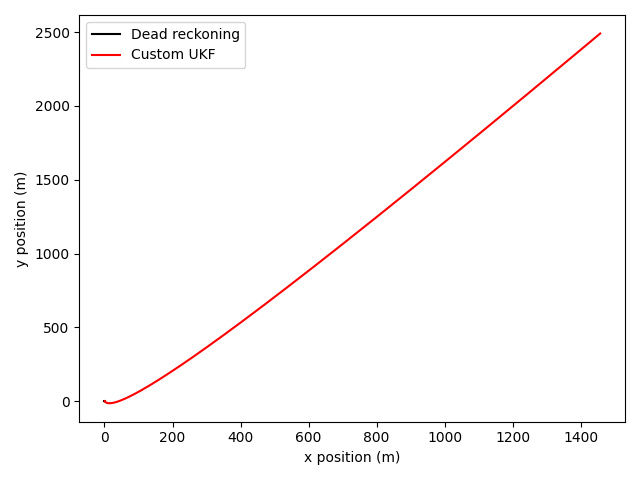

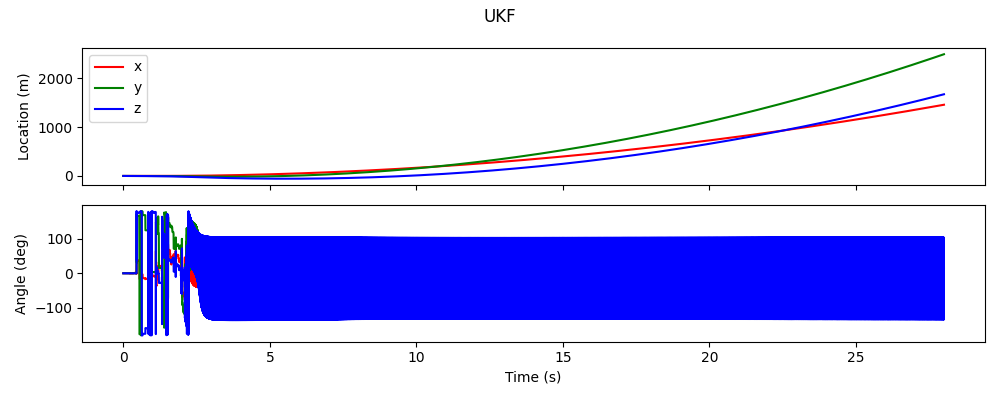

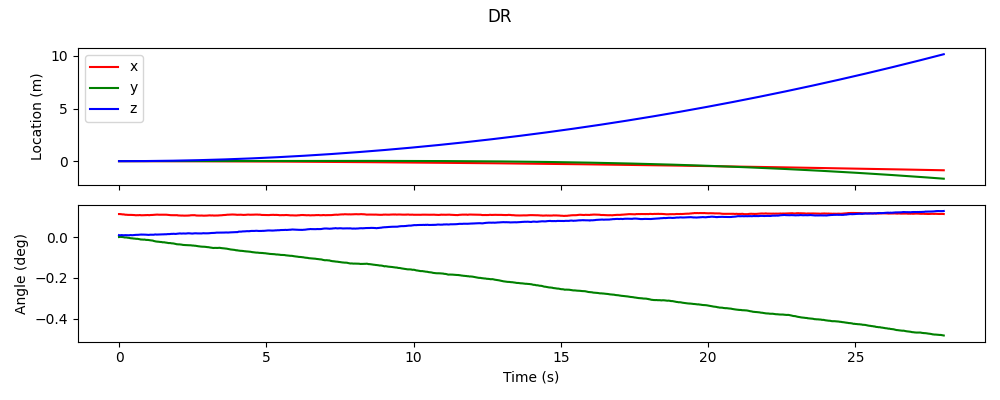

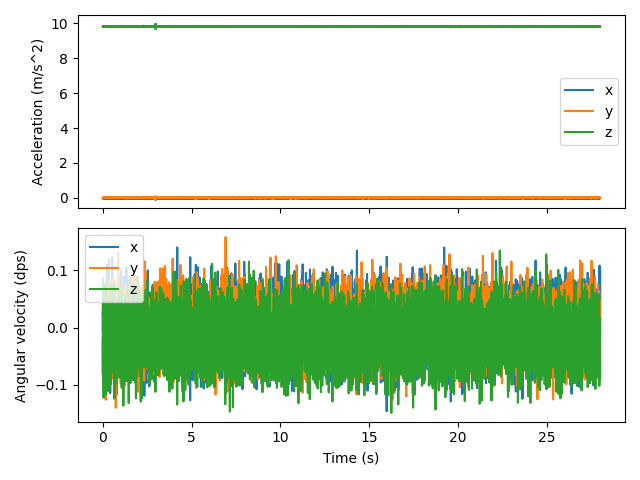

In [11]:
Q_list = [1e-4]
    # Process noise covariance (Too slow to react? Increase Q; Too sensitive to noise? Decrease the Q)
for Q in Q_list:
    config = UkfConfig(
        state_n=len(Location3d.state_names), measurement_n=6,
        alpha=1e-1, beta=2, kappa=0,
        Q=Q, P=1e-4, R=np.array(calibration['R']),
        init_r=init_r
    )
    # print(f"ALPHA: {alpha}")
    # run_location_tests(accelerometer, gyroscope, sample_rate, config)
    ukf_obj, dr_obj = run_location_tests(accelerometer, gyroscope, sample_rate, config, init_r)

plot(accelerometer, gyroscope, sample_rate)

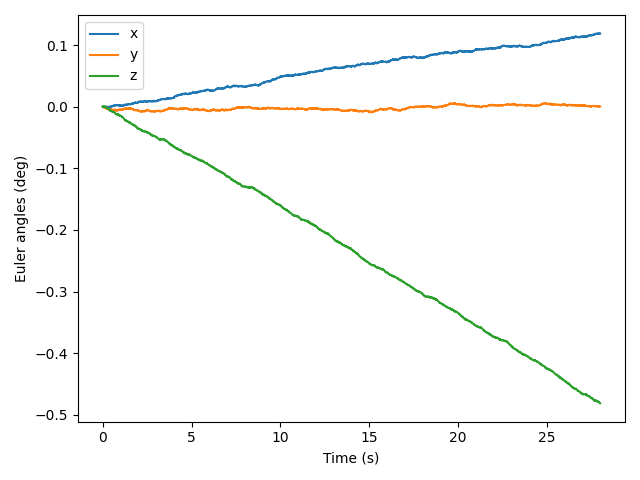

In [12]:
def dead_reckoning_gyro(gyro_data, dt):
    num_samples = len(gyro_data)
    orientation_history = np.zeros((num_samples, 4))  # To store quaternions representing the orientation in the world frame

    # Initial orientation is the identity quaternion (no rotation)
    current_orientation = R.from_quat([0, 0, 0, 1])

    for i, angular_velocity in enumerate(gyro_data):
        # Calculate the rotation vector (axis-angle representation) from angular velocities and elapsed time
        rotation_vector = angular_velocity * dt

        # Create a rotation object using the rotation vector
        delta_rotation = R.from_rotvec(rotation_vector)

        # Update the current orientation by multiplying with the delta rotation
        current_orientation = current_orientation * delta_rotation

        # Store the updated orientation as a quaternion in the history
        orientation_history[i] = current_orientation.as_quat()

    return orientation_history


orientation_history = dead_reckoning_gyro(gyroscope, 1/sample_rate)
# Convert orientation history in quats to Euler angles
euler_angles = R.from_quat(orientation_history).as_euler('xyz', degrees=True)
# Plot the orientation history
t = np.arange(len(euler_angles))/sample_rate
plt.figure()
plt.plot(t, euler_angles[:, 0], label='x')
plt.plot(t, euler_angles[:, 1], label='y')
plt.plot(t, euler_angles[:, 2], label='z')
plt.xlabel('Time (s)')
plt.ylabel('Euler angles (deg)')
plt.legend()
plt.tight_layout()
plt.show()

Sum Final Location: [-0.62135993  1.09444456 10.15589909]
DR Final Location: -0.867, -1.667, 10.155
Mean of rotated acceleration vector: [-0.00160392  0.0028338   0.02598982]
Estimated distance error: [-0.62873565  1.1108504  10.18801022]


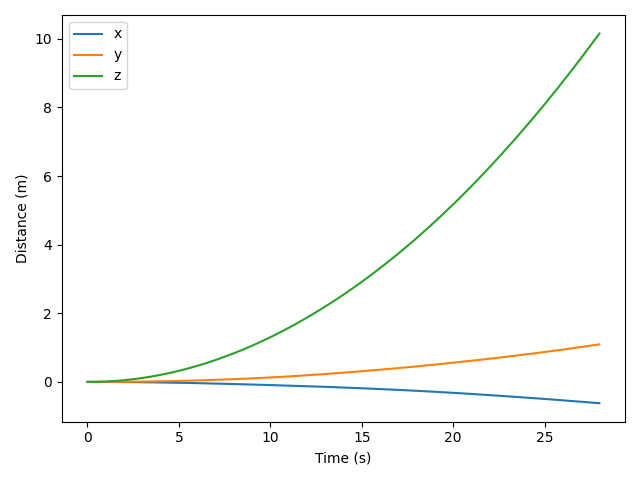

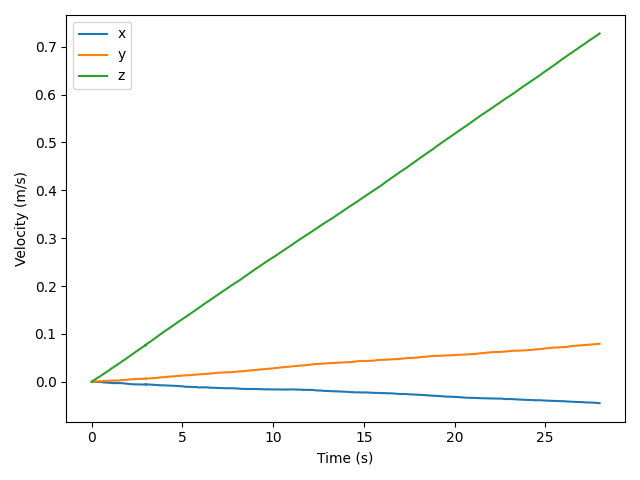

In [13]:
# Calculate the integral of the accelerometer data to get velocity and distance
rotated_accelerometer = init_r.apply(accelerometer)
velocity = np.cumsum(rotated_accelerometer - np.array([0, 0, Location3d.g]), axis=0) / sample_rate
distance = np.cumsum(velocity, axis=0) / sample_rate

# Print final location
print(f"Sum Final Location: {distance[-1]}")
state_df_dr = dr_obj.get_state_history_df()
print(f'DR Final Location: {state_df_dr.iloc[-1]["x_w"]:0.3f}, {state_df_dr.iloc[-1]["y_w"]:0.3f}, {state_df_dr.iloc[-1]["z_w"]:0.3f}')

print(f"Mean of rotated acceleration vector: {np.mean(rotated_accelerometer - np.array([0, 0, Location3d.g]), axis=0)}")
duration = len(accelerometer) / sample_rate
distance_error = 0.5 * np.mean(rotated_accelerometer - np.array([0, 0, Location3d.g]), axis=0) * duration**2
print(f"Estimated distance error: {distance_error}")

# Plot the velocity and distance
t = np.arange(len(velocity))/sample_rate
plt.figure()
plt.plot(t, velocity[:, 0], label='x')
plt.plot(t, velocity[:, 1], label='y')
plt.plot(t, velocity[:, 2], label='z')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.figure()
plt.plot(t, distance[:, 0], label='x')
plt.plot(t, distance[:, 1], label='y')
plt.plot(t, distance[:, 2], label='z')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.legend()
plt.tight_layout()
plt.show()
